In [119]:
from grizli import model
from grizli import multifit
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from matplotlib.gridspec import GridSpec
from astropy.table import Table
from astropy import wcs
from astropy.io import fits
from glob import glob
import seaborn as sea
import os

sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in","ytick.direction": "in"})

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

In [109]:
def Match_field(B_ra, B_dec, R_ra, R_dec):
    r = (1. / 60 ) * 2
    in_out = np.repeat(False,len(R_ra))          
    for i in range(len(R_ra)):
        cosr = np.sin(np.radians(B_dec)) * np.sin(np.radians(R_dec[i])) + np.cos(np.radians(B_dec))\
                * np.cos(np.radians(R_dec[i])) * np.cos(np.radians(B_ra) - np.radians(R_ra[i]))
        rad = np.arccos(cosr)
        rad = np.degrees(rad)
        if rad < r:
            in_out[i]= True
    return in_out

def Field_select(field_name,g102_flts,g141_flts):  ### finds source in flt file, returns if present and the pos in pixels
    clear_flts = []
    clear_ra = []
    clear_dec = []
    
    threed_ra = []
    threed_dec = []
    threed_flts = []
    
    for i in g102_flts:
        flt=fits.open(i)
        if flt[0].header['TARGNAME'] == field_name:
            clear_ra.append(flt[0].header['RA_TARG'])
            clear_dec.append(flt[0].header['DEC_TARG'])
            clear_flts.append(i) 
      
    RA = np.mean(clear_ra)
    DEC = np.mean(clear_dec)
    
    for i in g141_flts:
        flt=fits.open(i)
        threed_ra.append(flt[0].header['RA_TARG'])
        threed_dec.append(flt[0].header['DEC_TARG'])
    
    in_out = Match_field(RA,DEC,threed_ra,threed_dec)
    threed_flts = np.array(g141_flts)[in_out]
       
    return np.append(clear_flts,threed_flts)

In [75]:
Bflts = glob('/Users/vestrada/Clear_data/s_flt_files/*')
Rflts = glob('/Users/vestrada/3dhst/s_flt_files/*')

In [110]:
files = Field_select('ERSPRIME',Bflts,Rflts)

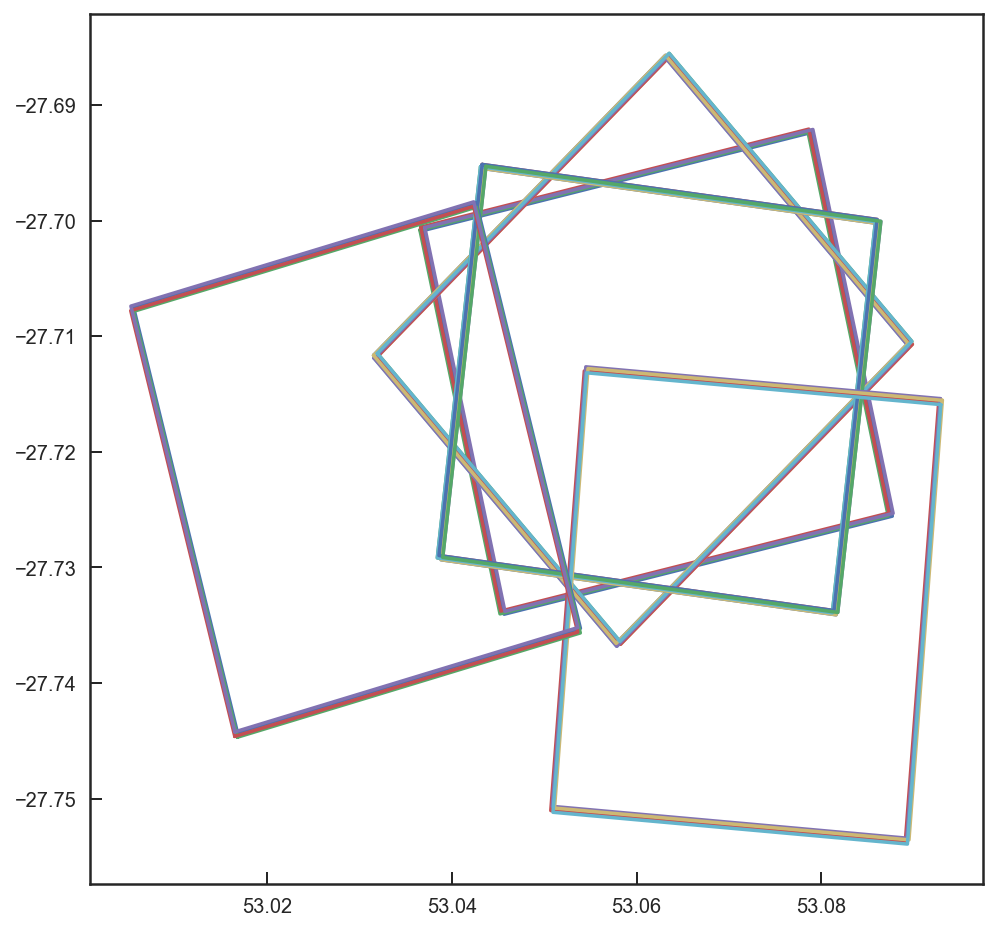

In [111]:
plt.figure(figsize=[8,8])
for i in files:
    flt = fits.open(i)
    w = wcs.WCS(flt[1].header)
    pos=w.wcs_pix2world([[0,0],[len(flt[1].data),0],[len(flt[1].data),len(flt[1].data)],[0,len(flt[1].data)],[0,0]],1)

    xs,ys = pos.T

    plt.plot(xs,ys)

In [121]:
class Extract_Grism_flts(object):
    def __init__(self, grism_flts, field):
        self.grism_flts = grism_flts
        self.field = field
    
        if self.field == 'GSD':
            if hpath.strip('/Users/') == 'Vince.ec':
                self.mosaic = '/Volumes/Vince_research/Data/CLEAR/CATALOGS/goodss_v4.4/goodss-F105W-astrodrizzle-v4.4_drz_sci.fits'
                self.catalog = '/Volumes/Vince_research/Data/CLEAR/CATALOGS/goodss_v4.4/goodss-F105W-astrodrizzle-v4.4_drz_sub.cat'
            if hpath.strip('/Users/') == 'vestrada':
                self.mosaic = hpath + 'Data/CLEAR/CATALOGS/goodss_v4.4/goodss-F105W-astrodrizzle-v4.4_drz_sci.fits'
                self.catalog = hpath + 'Data/CLEAR/CATALOGS/goodss_v4.4/goodss-F105W-astrodrizzle-v4.4_drz_sub.cat'

            self.seg_map = hpath + 'Clear_data/goodss_mosaic/goodss_3dhst.v4.0.F160W_seg.fits'
            self.ref_cat_loc = Table.read(hpath + 'Clear_data/goodss_mosaic/goodss_3dhst.v4.3.cat',format='ascii').to_pandas()

        if self.field == 'GND':
            if hpath.strip('/Users/') == 'Vince.ec':
                self.mosaic = '/Volumes/Vince_research/Data/CLEAR/CATALOGS/goodsn_v4.4/goodsn-F105W-astrodrizzle-v4.4_drz_sci.fits'
                self.catalog = '/Volumes/Vince_research/Data/CLEAR/CATALOGS/goodsn_v4.4/goodsn-F105W-astrodrizzle-v4.4_drz_sub.cat'
            if hpath.strip('/Users/') == 'vestrada':
                self.mosaic = hpath + 'Data/CLEAR/CATALOGS/goodsn_v4.4/goodsn-F105W-astrodrizzle-v4.4_drz_sci.fits'
                self.catalog = hpath + 'Data/CLEAR/CATALOGS/goodsn_v4.4/goodsn-F105W-astrodrizzle-v4.4_drz_sub.cat'

            self.seg_map = hpath + 'Clear_data/goodsn_mosaic/goodsn_3dhstP.seg.fits'
            self.ref_cat_loc = Table.read(hpath + 'Clear_data/goodsn_mosaic/goodsn_3dhstP.cat',format='ascii').to_pandas()
      
        self.ref_cat = Table.read(self.catalog,format='ascii')

 
        self.grp = multifit.GroupFLT(grism_files = self.grism_flts, direct_files = [], 
                      ref_file = self.mosaic,
                      seg_file = self.seg_map,
                      catalog = self.ref_cat,
                      cpu_count = 4,verbose = False)

        self.grp.compute_full_model(mag_limit=25, verbose=False)
        
        fig = plt.figure(figsize=[12,6])
        ax = fig.add_subplot(121)
        ax.imshow(self.grp.FLTs[0].grism['SCI'] - self.grp.FLTs[0].model, vmin=-0.02, vmax=0.2, cmap='cubehelix_r',
                  interpolation='Nearest', origin='lower')
        ax.set_title('G102, %s' %(self.grp.FLTs[0].grism.parent_file))

        ax = fig.add_subplot(122)
        ax.imshow(self.grp.FLTs[4].grism['SCI'] - self.grp.FLTs[4].model, vmin=-0.02, vmax=0.2, cmap='cubehelix_r',
                  interpolation='Nearest', origin='lower')
        ax.set_title('G141, %s' %(self.grp.FLTs[4].grism.parent_file))

        for ax in fig.axes:
            ax.set_xlim(500,700); ax.set_ylim(500,700)
        
        self.grp.refine_list(poly_order=2, mag_limits=[16, 24], verbose=False)

        fig = plt.figure(figsize=[12,6])
        ax = fig.add_subplot(121)
        ax.imshow(self.grp.FLTs[0].grism['SCI'] - self.grp.FLTs[0].model, vmin=-0.02, vmax=0.2, cmap='cubehelix_r',
                  interpolation='Nearest', origin='lower')
        ax.set_title('G102, %s' %(self.grp.FLTs[0].grism.parent_file))

        ax = fig.add_subplot(122)
        ax.imshow(self.grp.FLTs[4].grism['SCI'] - self.grp.FLTs[4].model, vmin=-0.02, vmax=0.2, cmap='cubehelix_r',
                  interpolation='Nearest', origin='lower')
        ax.set_title('G141, %s' %(self.grp.FLTs[4].grism.parent_file))

        for ax in fig.axes:
            ax.set_xlim(500,700); ax.set_ylim(500,700)

Image cutout: x=slice(11038, 15857, None), y=slice(13803, 18276, None)
Image cutout: x=slice(11062, 15881, None), y=slice(13805, 18278, None)
Image cutout: x=slice(11057, 15876, None), y=slice(13819, 18293, None)
Image cutout: x=slice(11033, 15852, None), y=slice(13817, 18291, None)
The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    



The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           m

Image cutout: x=slice(10755, 16255, None), y=slice(13424, 18882, None)
Image cutout: x=slice(10777, 16276, None), y=slice(13414, 18872, None)
Image cutout: x=slice(10780, 16279, None), y=slice(13429, 18887, None)
Image cutout: x=slice(10759, 16258, None), y=slice(13440, 18897, None)
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Image cutout: x=slice(10759, 16258, None), y=slice(13440, 18897, None)
Image cutout: x=slice(10777, 16276, None), y=slice(13414, 18872, None)
Image cutout: x=slice(10755, 16255, None), y=slice(13424, 18882, None)
Image cutout: x=slice(10780, 16279, None), y=slice(13429, 18887, None)
/Users/vestrada/Clear_data/s_flt_files/icxt20fbq_flt.fits / Pad ref HDU with 50 pixels
/Users/vestrada/Clear_data/s_flt_files/icxt20fdq_flt.fits / Pad ref HDU with 50 pixels
/Users/vestrada/Clear_data/s_flt_files/icxt20f7q_flt.f

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3452: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3457: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3458: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1214: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf 

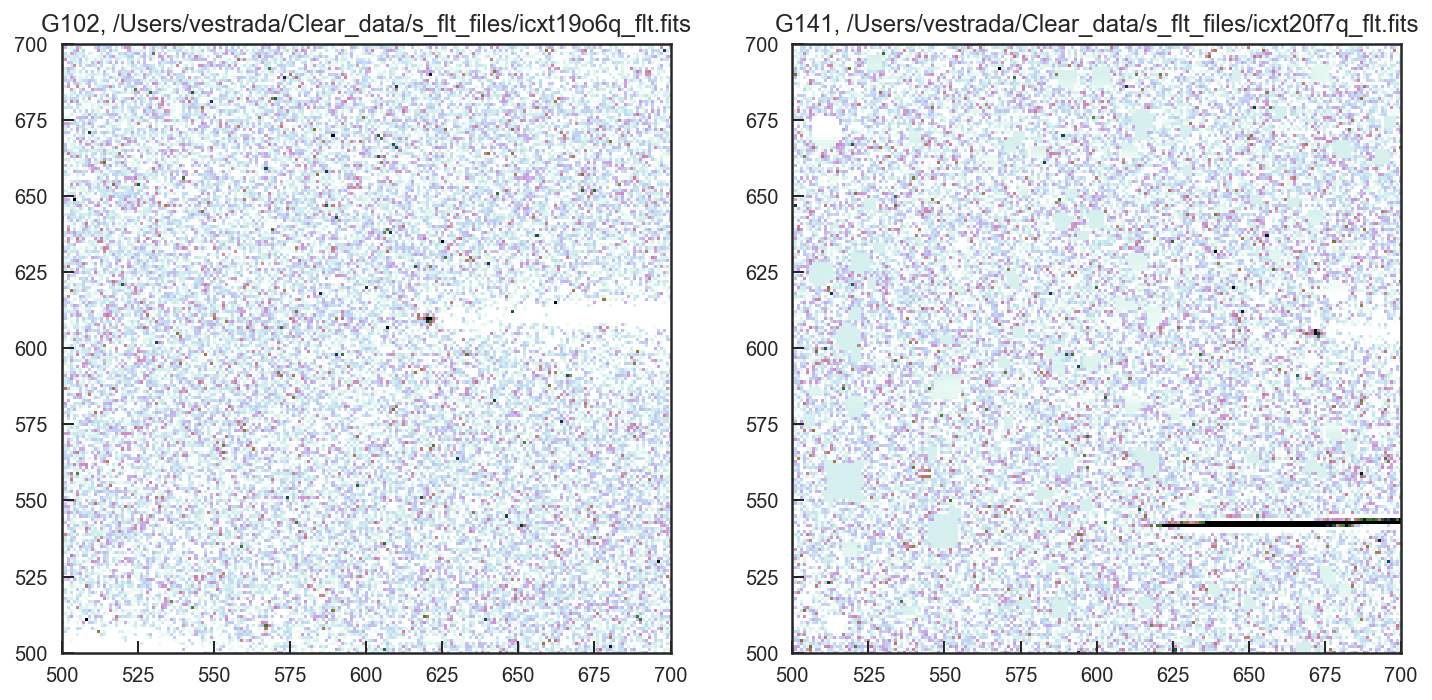

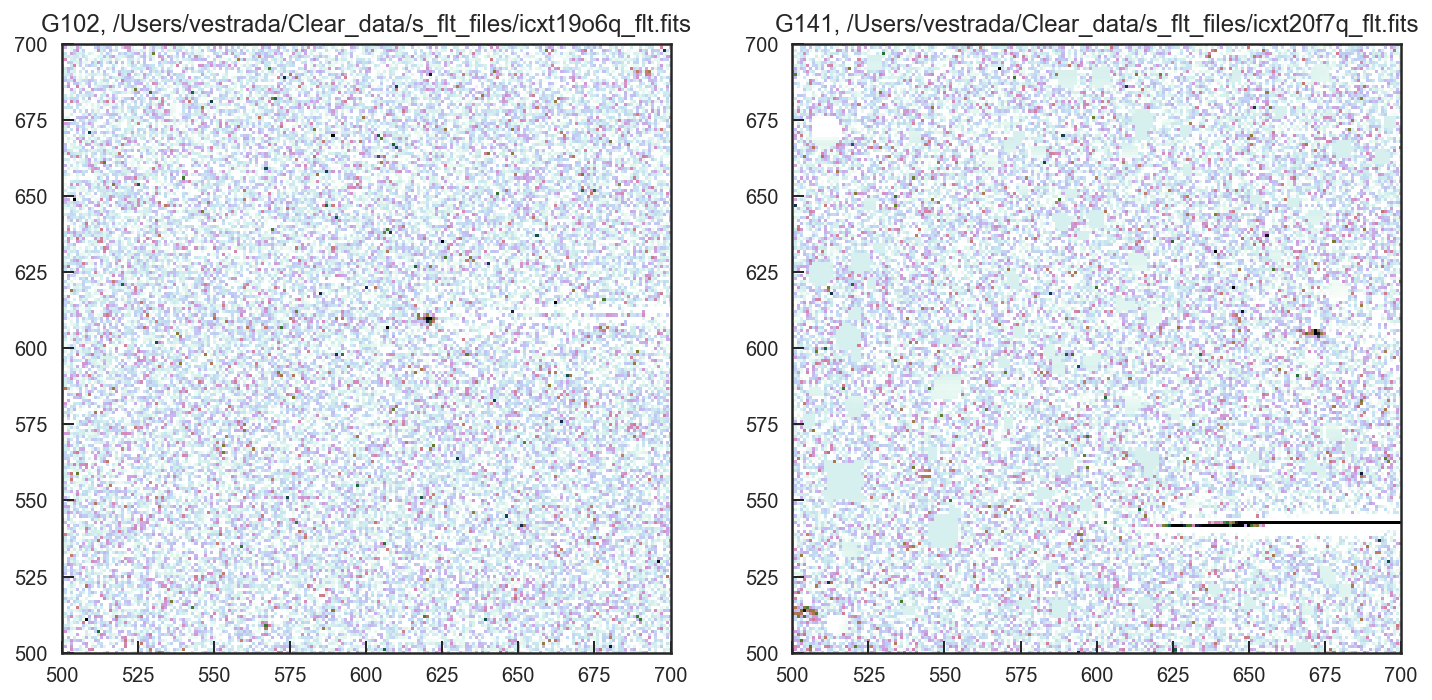

In [123]:
ex = Extract_Grism_flts(files,'GSD')

In [ ]:
ex.grp.save_full_data()